- Why bother to learn about mixture models? 
- Why use them, what's the benefit of the extra effort to learn these techniques? 
- How can they be applied to trading?

In this chapter I'll set out to answer the aforementioned questions in a mostly show don't tell fashion. However before I can explain the significance of these techniques we have to cover some foundational material about time series prediction.

### Import modules and tools

In [1]:
%load_ext watermark
%watermark

# import standard libs

import sys
import os
import time

# import python scientific stack

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
import pymc3 as pm

# import visual tools

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# set globals
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['figure.figsize'] = 9,7

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777
dfwaic = pd.DataFrame() # setup for WAIC evaluations

print()
%watermark -p pymc3,pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

2017-10-25T09:47:56-06:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.0-97-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/media/files/anaconda3/envs/pymc3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pymc3 3.1
pandas 0.20.3
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 0.19.1
matplotlib 2.0.2
seaborn 0.8.1
plotnine 0.2.1+13.g65bdce6
pyarrow 0.7.0


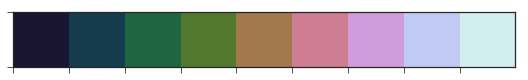

In [2]:
sns.palplot(sns.color_palette('cubehelix', 9))

In [3]:
# some conv fns

def cprint(df):
    print('-'*79)
    print('dataframe information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)    
    print()
    
get_range = lambda df, col: (df[col].min(), df[col].max())
get_pct_shape = lambda df, col: (df[col].nunique() / df[col].shape[0])

#### First let's get some market data from Yahoo. We'll get the adjusted closing price for multiple ETFs. 

In [4]:
get_price = lambda sym, start, end: web.DataReader(sym, 'yahoo', start, end)['Adj Close']

#f1 = 'TEDRATE' # ted spread
#f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
#f3 = 'T10Y3M' # constant maturity 10yr - 3m
#factors = [f1, f2, f3]

chosen_syms = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

end = pd.to_datetime('2017-09-30')
start = end - 25 * 252 * pd.tseries.offsets.BDay()

#%time df = (pd.DataFrame({sym:get_price(sym, start, end) for sym in chosen_syms}).dropna())


next we create the return dataframe and save it using pyarrow. this dataset is small enough to save as csv or h5 but if you intend on dealing with larger datasets I recommend developing the pyarrow habit now.

In [5]:
#rs = np.log(df/df.shift(1)).dropna()
#cprint(rs)

In [6]:
save_parquet = lambda df, save_fp: pq.write_table(pa.Table.from_pandas(df), save_fp)

pdir = '/media/files/_Code/mixture_model_trading/'
#save_fp = pdir + f'data/etf_returns_{rs.index.min().date()}-{rs.index.max().date()}.parquet'
#save_parquet(rs, save_fp)

In [7]:
load_parquet = lambda fp: pq.read_table(fp)

load_fp = pdir+'data/etf_returns_2004-11-19-2017-09-29.parquet'
rs = (load_parquet(load_fp).to_pandas())
cprint(rs)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               EEM     EFA     GLD     QQQ     SPY     TLT
Date                                                      
2017-09-25 -0.0171 -0.0057  0.0104 -0.0106 -0.0020  0.0062
2017-09-26 -0.0027 -0.0022 -0.0112  0.0026  0.0006 -0.0018
2017-09-27 -0.0036  0.0007 -0.0095  0.0090  0.0039 -0.0152
2017-09-28 -0.0007  0.0026  0.0019 -0.0003  0.0012 -0.0030
2017-09-29  0.0114  0.0059 -0.0052  0.0072  0.0035  0.0022
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 6 columns):
EEM    3238 non-null float64
EFA    3238 non-null float64
GLD    3238 non-null float64
QQQ    3238 non-null float64
SPY    3238 non-null float64
TLT    3238 non-null float64
dtypes: float64(6)
memory usage: 177.1 KB
None
---------

In [8]:
def vertical_mean_line2(x, **kwargs):
    ls = {"0":"-","1":"--"}
    #alpha5, alpha95 = pm.hpd(x)
    mean, std = x.mean(), x.std()
    
    #plt.axvline(mean, linestyle =ls[kwargs.get("label","0")], 
    #            color = kwargs.get("color", "g"))
    txkw = dict(size=14, fontweight='demi', color=kwargs.get("color", "g"), rotation=0)

    mean_tx = "mean: {:.4%}\nstd: {:.4%}".format(mean, std)
    #std_tx = "".format(std)
    
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.8*ymax, mean_tx, **txkw)
             #bbox=dict(facecolor='none', edgecolor=blue, boxstyle='round'))
    return
    
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""

def plot_dist(rs, ex):
    plt.style.use('dark_background')

    #ex = rs.SPY
    plt.rcParams['font.size'] = 14
    g = (rs
         .pipe(sns.FacetGrid, 
               #col='year',
               #col_wrap=2,
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex.name, kde=False, fit=stats.norm, fit_kws={'color':green, 'lw':2.5})
         .map(sns.distplot, ex.name, kde=False, fit=stats.laplace, fit_kws={'linestyle':'-', 'color':gold, 'lw':2.5})
         .map(sns.distplot, ex.name, kde=False, fit=stats.johnsonsu,fit_kws={'linestyle':'-', 'color':purple, 'lw':2.5})
         .map(vertical_mean_line2, ex.name))
    return
    
def plot_facet_hist(rs, ex):
    plt.style.use('dark_background')
    #plt.style.use('seaborn-ticks')
    #ex = rs.SPY
    plt.rcParams['font.size'] = 12
    g = (rs.assign(year=lambda df: df.index.year)
         .pipe(sns.FacetGrid, 
               col='year',
               col_wrap=2,
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex.name, kde=False, fit=stats.norm, fit_kws={'color':green, 'lw':2.5})
         .map(sns.distplot, ex.name, kde=False, fit=stats.laplace, fit_kws={'linestyle':'-', 'color':gold, 'lw':2.5})
         .map(sns.distplot, ex.name, kde=False, fit=stats.johnsonsu,fit_kws={'linestyle':'-', 'color':purple, 'lw':2.5})
         .map(vertical_mean_line2, ex.name)
         .fig.subplots_adjust(hspace=.20))
    sns.despine(offset=1, trim=True)
    return

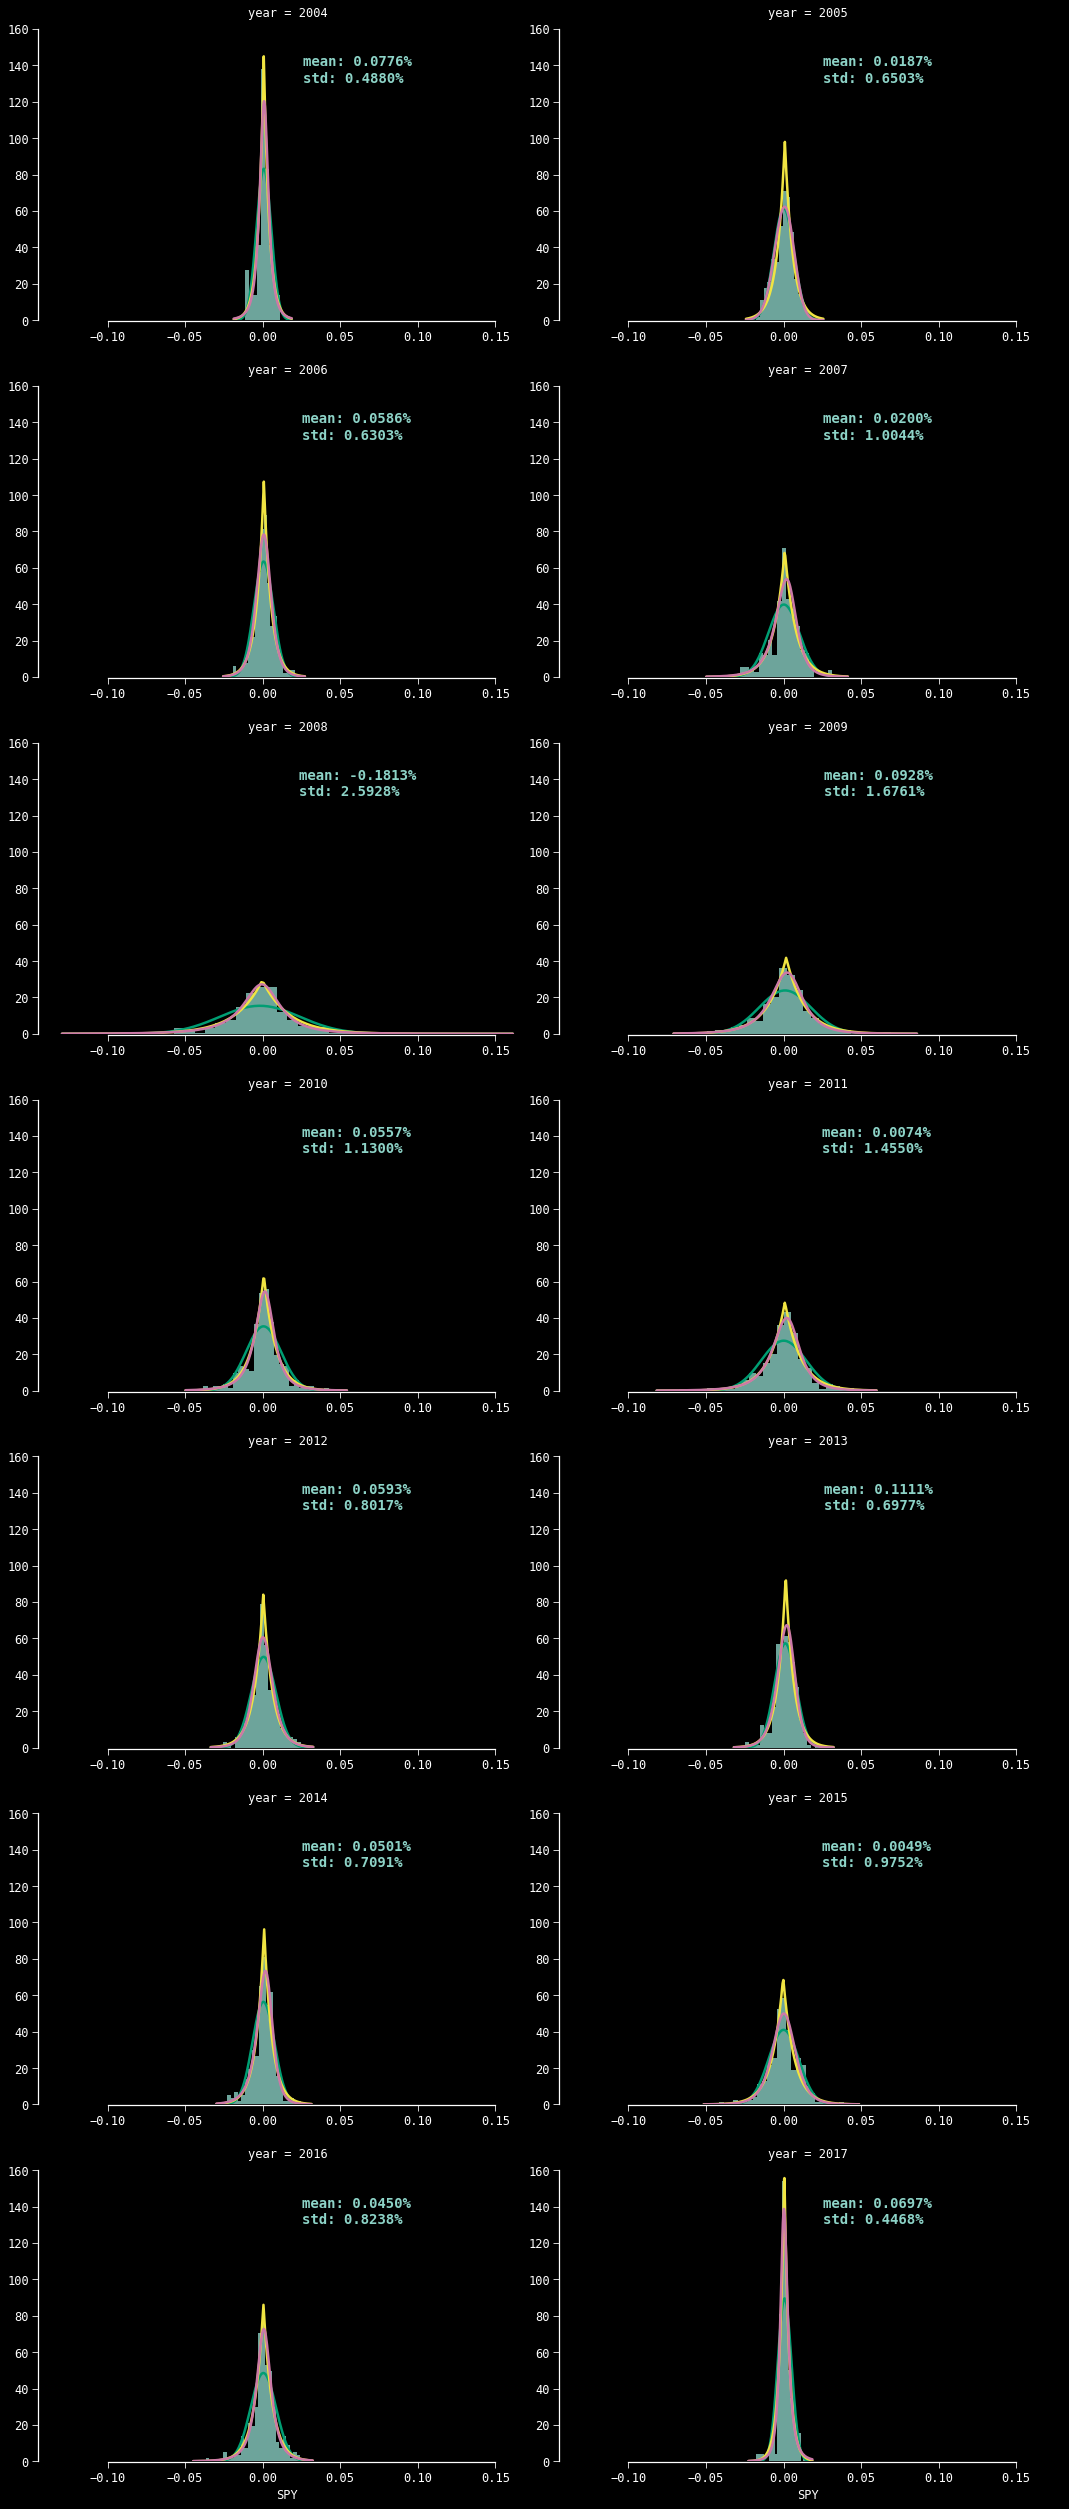

In [9]:
 plot_facet_hist(rs, rs.SPY)    

Now let's look at a canonical example of a return distribution using the SPY etf. 

In [10]:
def vertical_mean_line2(x, **kwargs):
    ls = {"0":"-","1":"--"}
    #alpha5, alpha95 = pm.hpd(x)
    mean = x.mean()
    plt.axvline(mean, linestyle =ls[kwargs.get("label","0")], 
                color = kwargs.get("color", "g"))
    txkw = dict(size=12, color = kwargs.get("color", "g"), rotation=90)

    tx = f"mean: {mean:.4f}"
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.01, 0.9*ymax, tx, **txkw)   

In [11]:
ex = rs.SPY

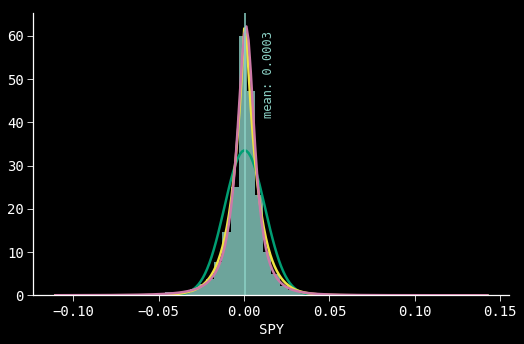

In [12]:
plot_dist(rs, ex)

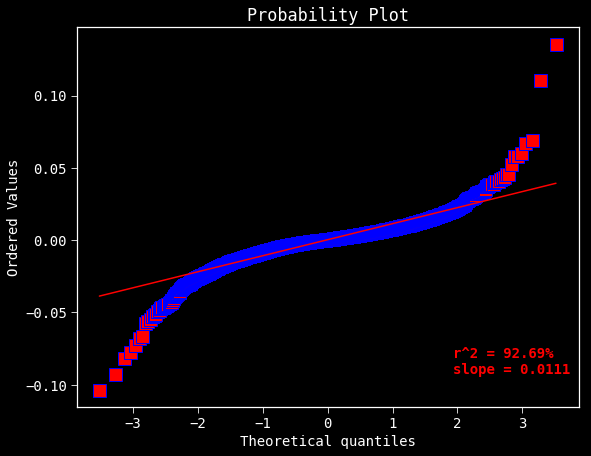

In [13]:
def plot_qq(y, *args, **kwargs): 
    #if not isinstance(y, pd.Series):
    #    y = pd.Series(y)
        
    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'dejavu sans mono'
    pp = sm.ProbPlot(y, fit=True)
    qq = pp.qqplot(marker='+', markersize=15, markerfacecolor=blue, markeredgecolor=blue, alpha=0.75)
    sm.qqline(qq.axes[0], line='45', fmt='r--')
    #plt.title('QQ Plot of Returns', fontsize=18, fontweight='demi')
    
    
    
def quantile_plot(x, **kwargs):
    #qntls, xr = stats.probplot(x, fit=True, plot=plt)
    plt.rcParams['font.family'] = 'dejavu sans mono'
    res = stats.probplot(x, fit=True, plot=plt)
    _slope, _int, _r = res[-1]

    ax = plt.gca()
    ax.get_lines()[0].set_marker('s')
    ax.get_lines()[0].set_markerfacecolor('r')
    ax.get_lines()[0].set_markersize(13.0)
    ax.get_children()[-2].set_fontsize(22.)
    
    txkw = dict(size=14, fontweight='demi', color='r')
    r2_tx = "r^2 = {:.2%}\nslope = {:.4f}".format(_r, _slope)
    
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.text(0.5*xmax, .8*ymin, r2_tx, **txkw)
    #plt.scatter(xr, qntls, **kwargs)
    
    #xlim = np.linspace(xr.min(), xr.max())
    #ylim = np.linspace(qntls.min(), qntls.max())
    #plt.plot(xlim, ylim, 'r--', clip_on=True, scalex=False, scaley=False)
  
    
#plot_qq(ex)    
ex = rs.SPY.loc['2005':]
quantile_plot(ex)#.loc['2014'])#, marker='+')

In [14]:
def plot_facet_qq(rs, ex):
    #plt.style.use('dark_background')
    
    #lt.rcParams['font.size'] = 12
    
    g = (rs.assign(year=lambda df: df.index.year)
         .pipe(sns.FacetGrid, 
               col='year',
               col_wrap=2,
               size=7,
               aspect=1.3)
         .map(quantile_plot, ex.name)
         .fig.subplots_adjust(hspace=.20))
    sns.despine(offset=1, trim=True)
    return

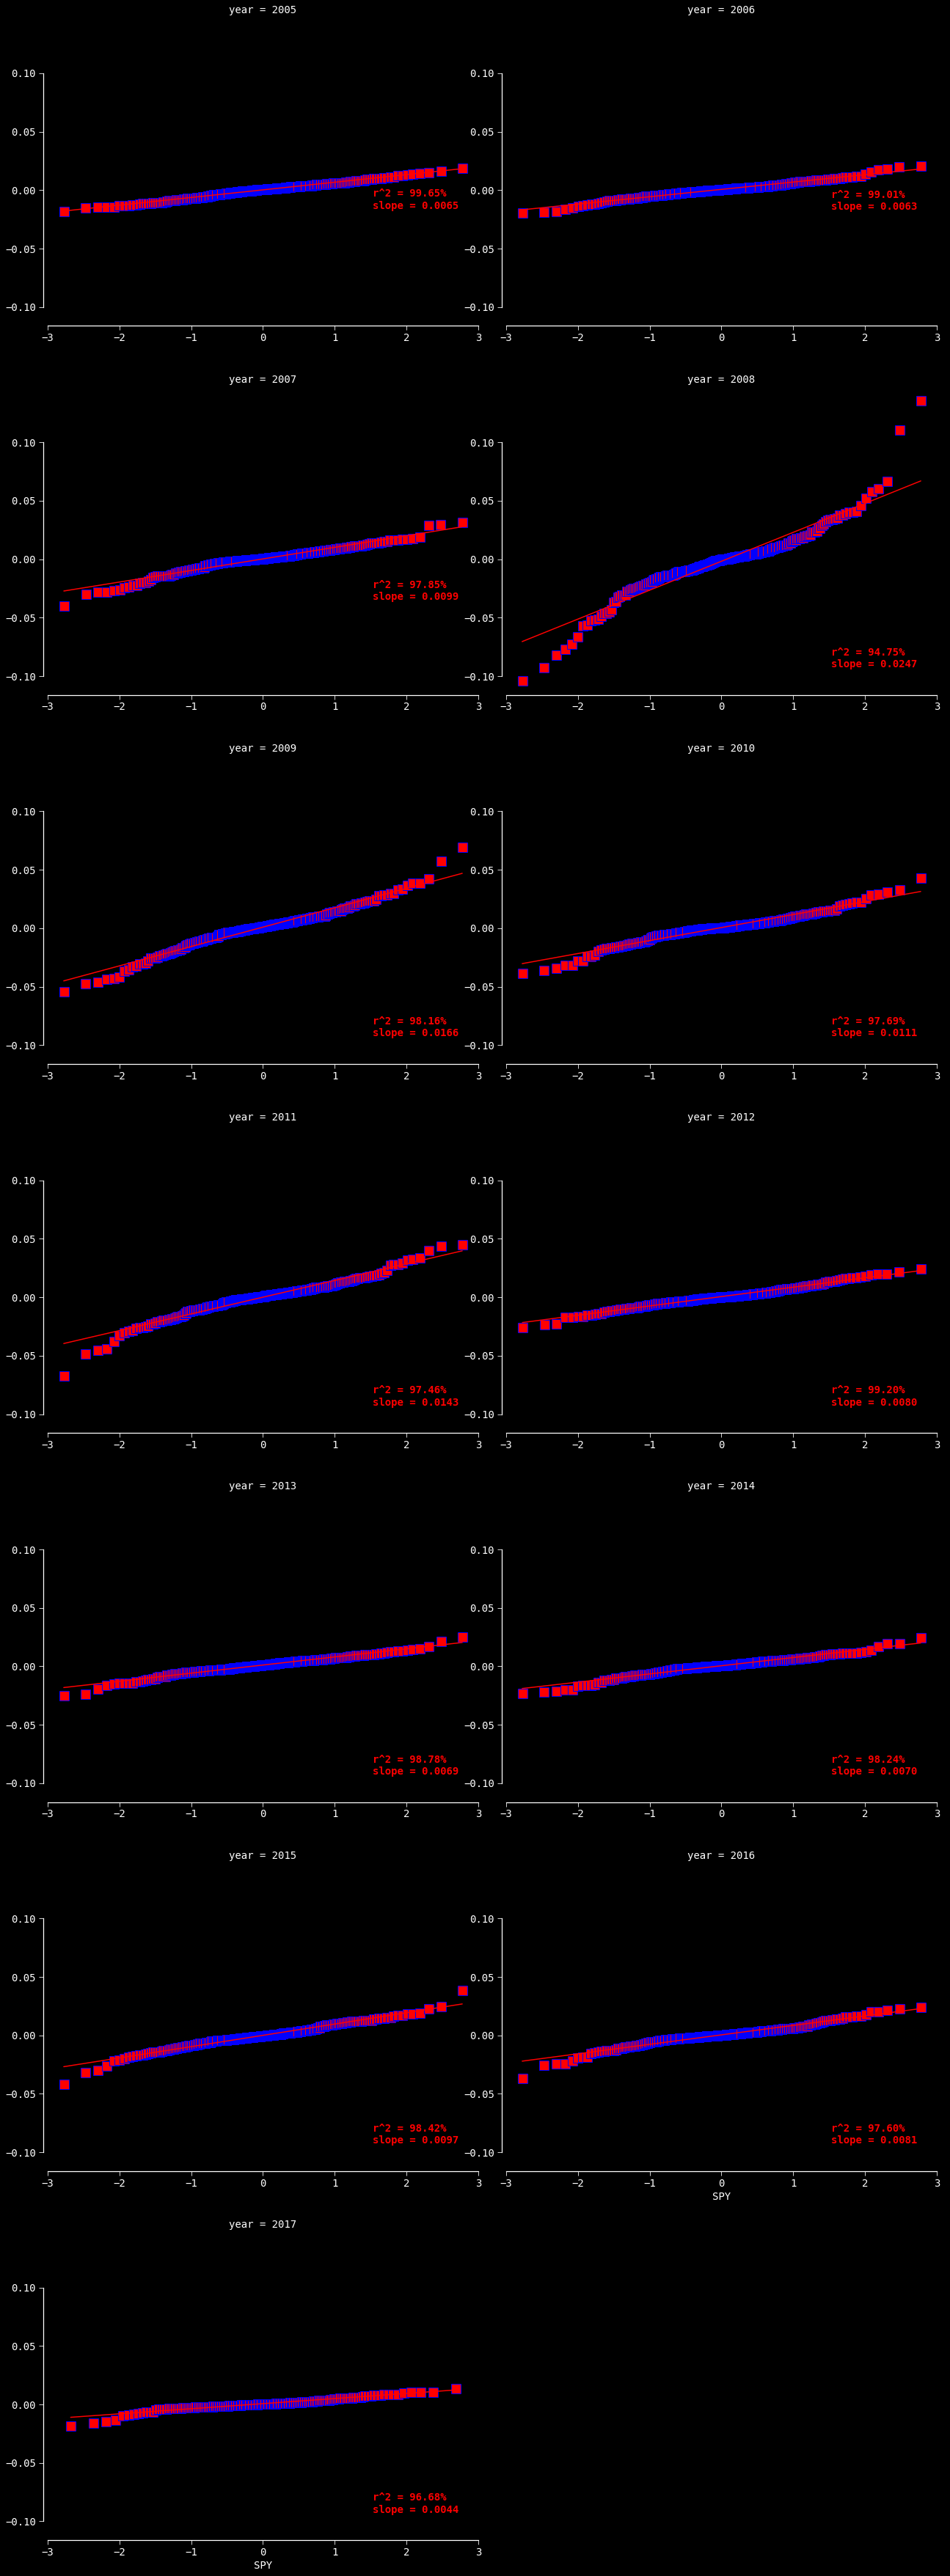

In [15]:
plot_facet_qq(rs.loc['2005':], ex)    

In [129]:
norm = stats.norm
laplace = stats.laplace
jsu = stats.johnsonsu

def generate_norm_rvs(ser, N=None):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = norm(ser.mean(), ser.std()).pdf(x)
    return x, y

def generate_norm_cdf(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = norm.cdf(x, ser.mean(), ser.std())
    return x, y

def generate_laplace_rvs(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = laplace(ser.mean(), ser.std()).pdf(x)
    return x, y

def generate_laplace_cdf(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = laplace.cdf(x, ser.mean(), ser.std())
    return x, y

def generate_jsu_rvs(ser, a, b):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = jsu(a, b, loc=ser.mean(), scale=ser.std()).pdf(x)
    return x, y

def generate_jsu_cdf(ser, a, b):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = jsu.cdf(x, a, b, loc=ser.mean(), scale=ser.std())
    return x, y

a = 0.01
b = 0.99

def plot_all_pdf(ex, a, b, ax=None):
    normx, normy = generate_norm_rvs(ex)
    lpcx, lpcy = generate_laplace_rvs(ex)
    x, y = generate_jsu_rvs(ex, a, b)
    #x, y = generate_jsu_cdf(ex, a, b)
    if not ax:
        fig, ax = plt.subplots()
    sns.kdeplot(ex, ax=ax, color=purple, label='$returns$')
    pd.Series(normy, index=normx).plot(ax=ax, color=green, label='norm')
    pd.Series(lpcy, index=lpcx).plot(ax=ax, color=red, label='laplace')
    pd.Series(y, index=x).plot(ax=ax, color=blue, label='jsu')
    plt.legend()

In [17]:
inc = 0.1
_as = np.arange(0.0, 0.5+inc, inc)
_bs = np.arange(0.5, 2.+inc, inc)    
len(_as) * len(_bs)

96

CPU times: user 55.6 s, sys: 17.2 s, total: 1min 12s
Wall time: 52.7 s


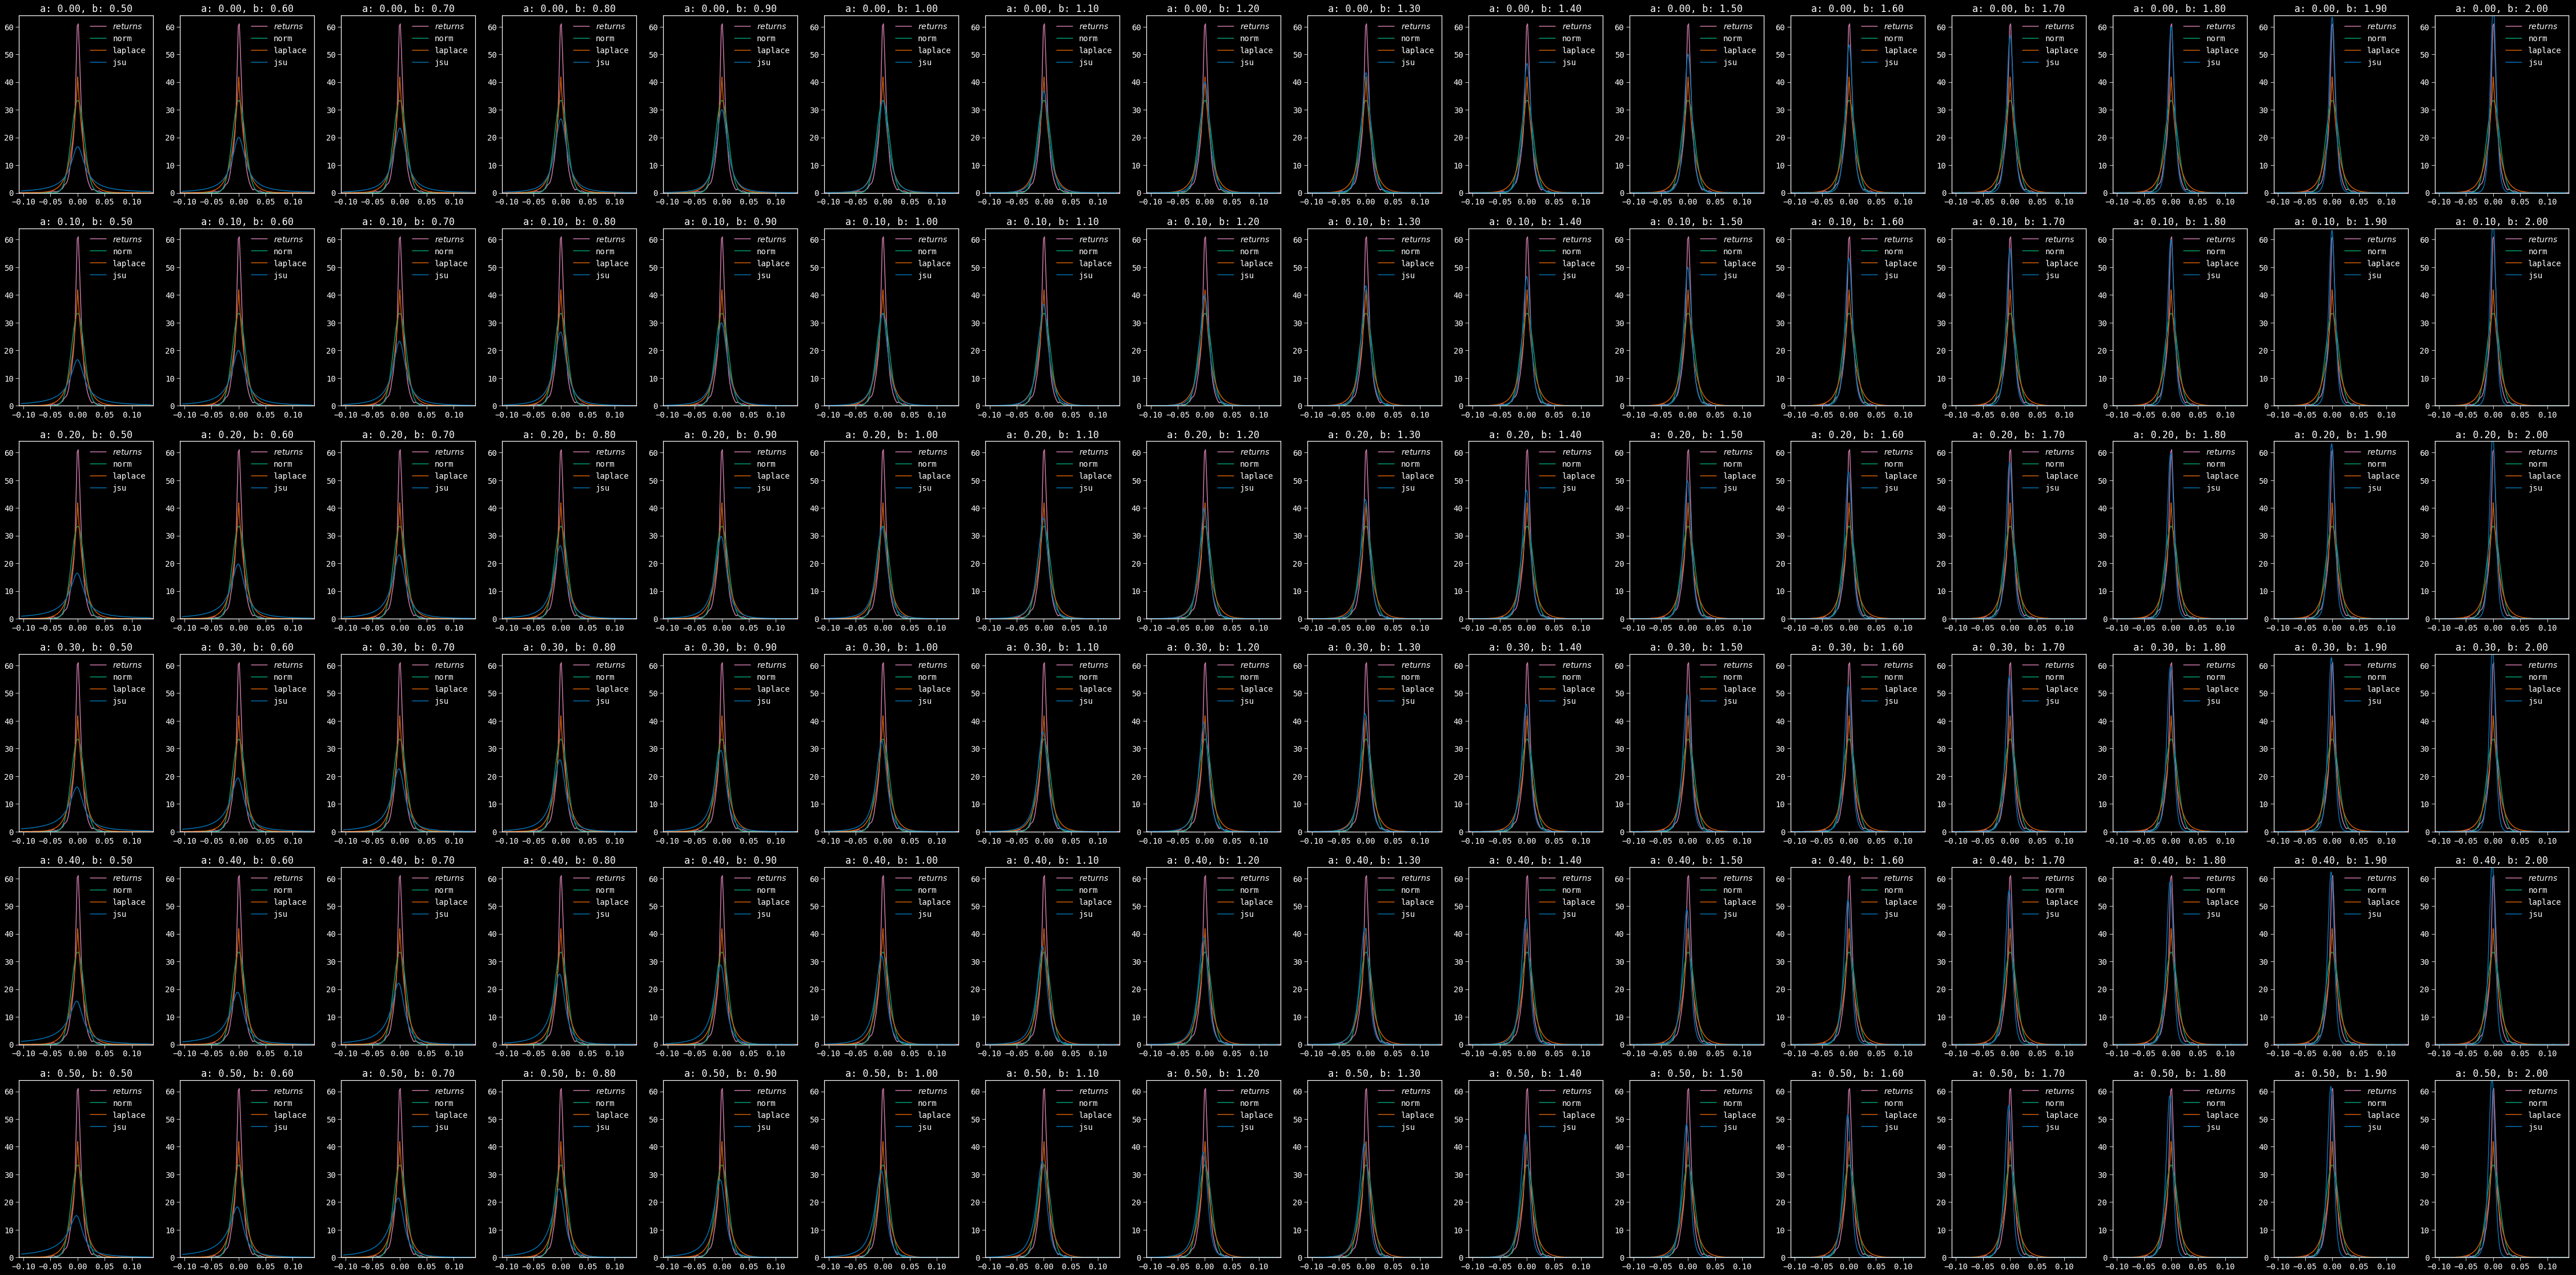

In [18]:
%%time

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(len(_as), len(_bs))

fig = plt.figure(figsize=(80,40))

for i, a in enumerate(_as):
    for j, b in enumerate(_bs):
        tmp_ax = plt.subplot(gs[i, j])
        plot_all_pdf(ex, a, b, ax=tmp_ax)
        plt.title('a: {:.2f}, b: {:.2f}'.format(a, b))
plt.savefig('spy return pdf compare.png', dpi=300, bbox_inches='tight')

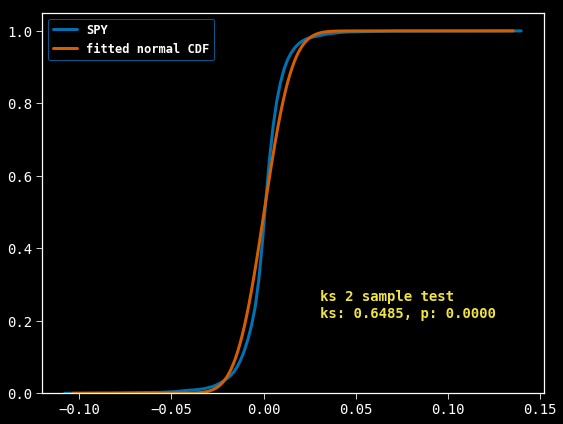

In [128]:
def plot_cdf(ex, **kwargs):     
    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'dejavu sans mono'
    
    x, y = generate_norm_cdf(ex)
    g = sns.kdeplot(ex, cumulative=True, lw=3,
                     #hist_kws={'cumulative':True, 'alpha':0.5},
                     #kde_kws={'cumulative':True, 'lw':3, 'label':'return CDF'},
                     color=blue)
    g.plot(x, y, color=red, lw=3, label='fitted normal CDF')
    
    ks, p = stats.ks_2samp(ex, y)
    
    xmin,xmax=plt.gca().get_xlim()
    ymin,ymax=plt.gca().get_ylim()
    
    txkw = dict(size=14, fontweight='demi', color=gold, rotation=0)
    tx = 'ks 2 sample test\nks: {:.4f}, p: {:.4f}'.format(ks,p)
    plt.text(xmax*0.2, 0.2*ymax, tx, **txkw)    
    #g.fill_between(x, 0, y, color=red, alpha=0.03)
    #sns.despine(offset=2, trim=True)
    (plt.legend(frameon=True, prop={'weight':'demi', 'size':12})
     .get_frame()
     .set_edgecolor(blue))
    
plot_cdf(ex)    

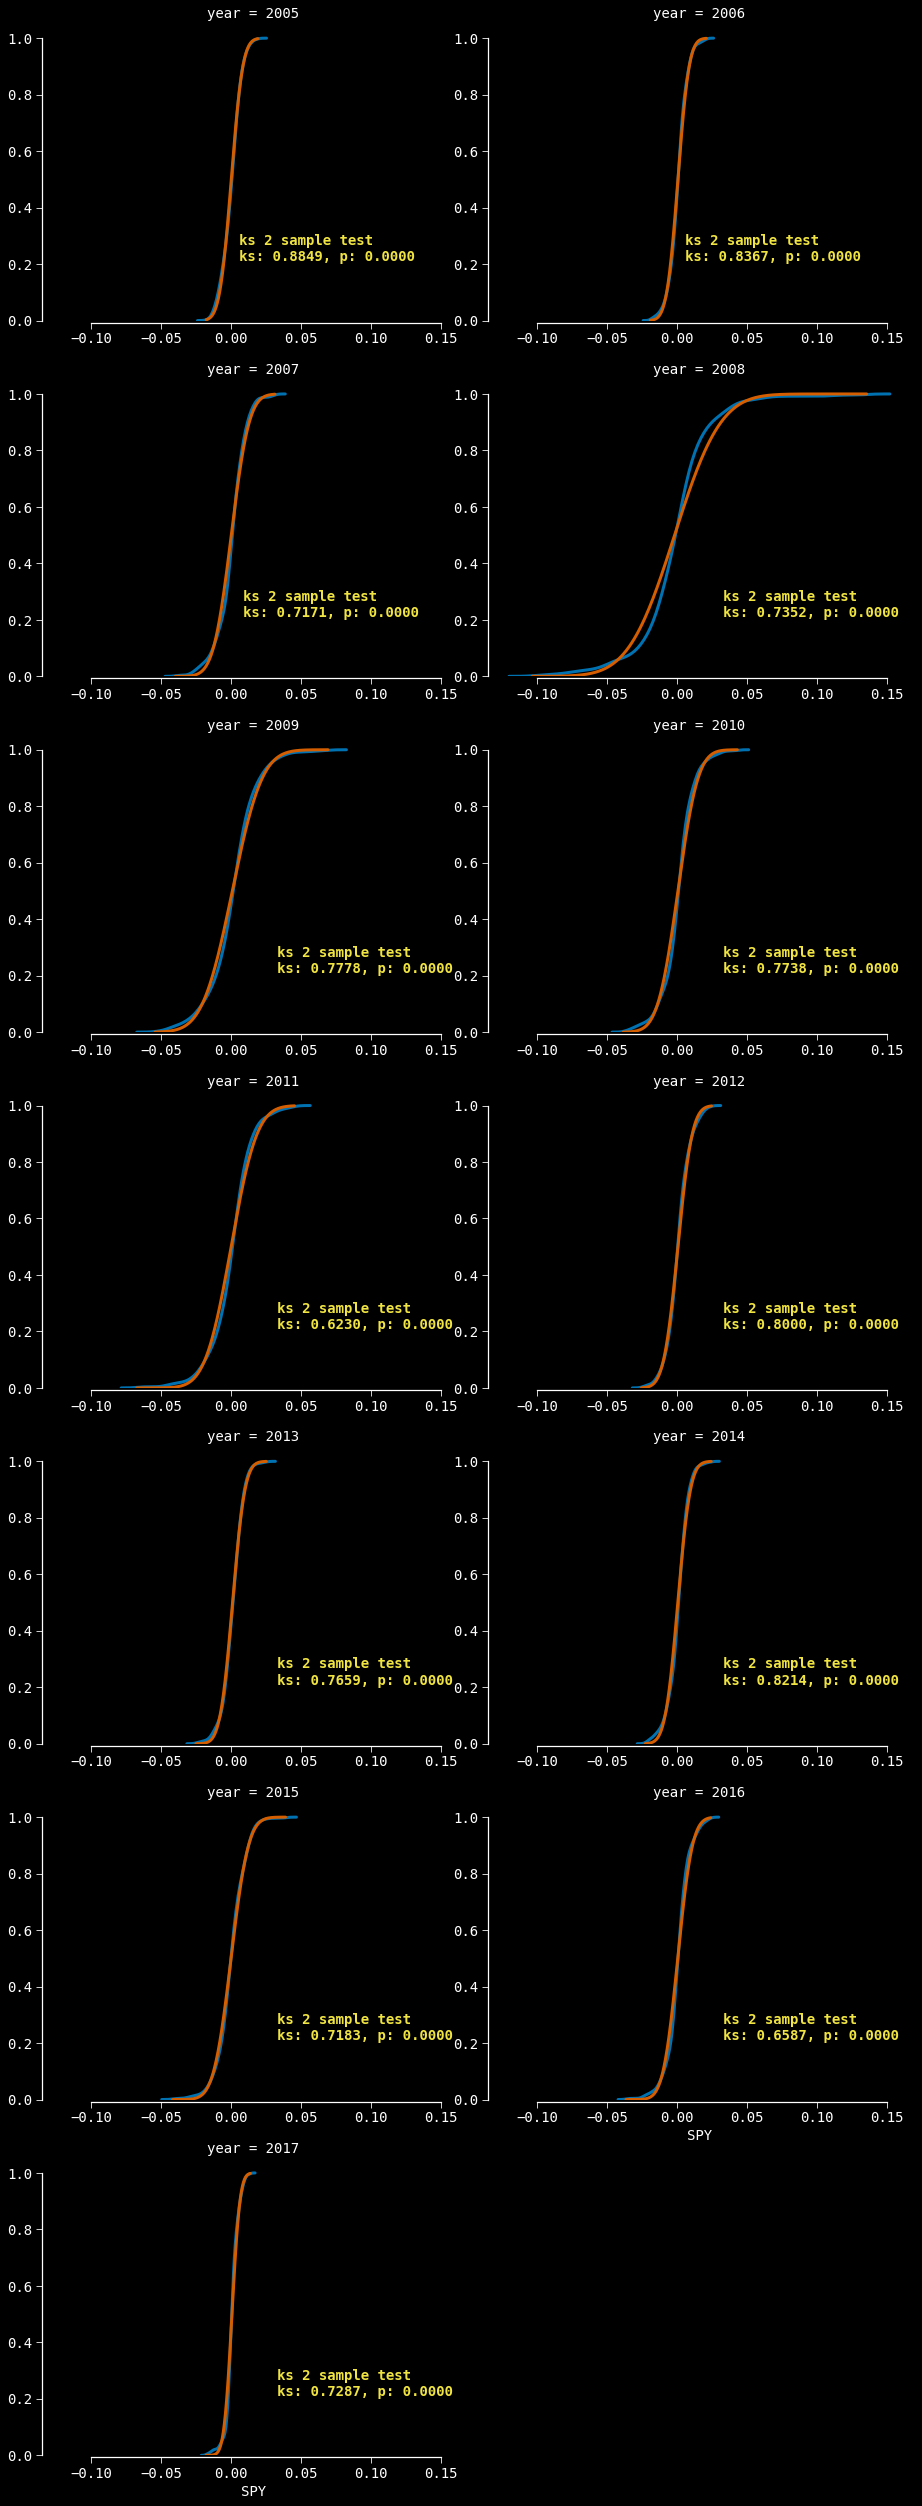

In [126]:
def plot_facet_cdf(rs, ex):
    #plt.style.use('dark_background')
    
    #lt.rcParams['font.size'] = 12
    
    g = (rs.assign(year=lambda df: df.index.year)
         .pipe(sns.FacetGrid, 
               col='year',
               col_wrap=2,
               size=5,
               aspect=1.3)
         .map(plot_cdf, ex.name)#, ex.name)
         .fig.subplots_adjust(hspace=.20))
    sns.despine(offset=2, trim=True)
    return

plot_facet_cdf(rs.loc['2005':], ex)

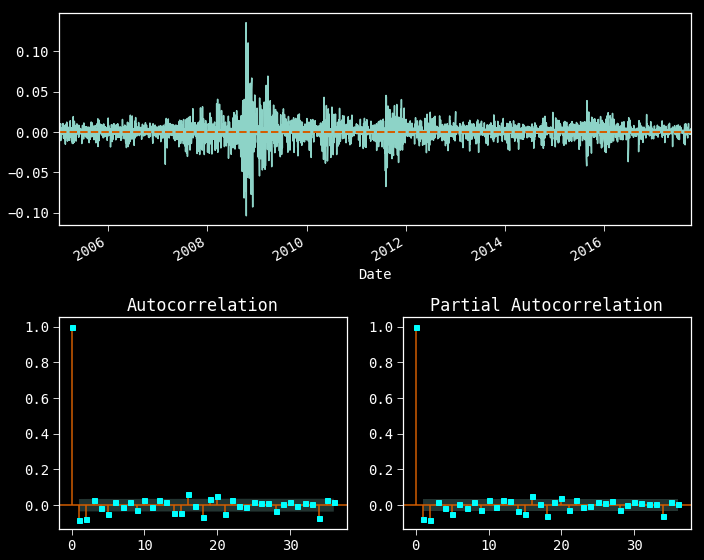

In [21]:
def tsplot(y, lags=None, figsize=(10, 8), style='dark_background'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    #plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'dejavu sans mono'        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        #qq_ax = plt.subplot2grid(layout, (2, 0))
        #pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.axhline(0, color=red, ls='--', lw=2.)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, color=red)
        acf_ax.get_lines()[1].set_marker('s');
        acf_ax.get_lines()[1].set_markerfacecolor('cyan');
        acf_ax.get_lines()[1].set_markeredgecolor('cyan');
        #acf_ax.get_lines()[1].set_linestyle('--')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, color=red)
        pacf_ax.get_lines()[1].set_marker('s');
        pacf_ax.get_lines()[1].set_markerfacecolor('cyan');
        pacf_ax.get_lines()[1].set_markeredgecolor('cyan');
        #sm.qqplot(y, line='s', ax=qq_ax)
        #stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        #acf_arr = smt.acf(y, nlags=lags)
        #pacf_arr = smt.pacf(y, nlags=lags)
        #[ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
        #[ax.set_yscale('log') for ax in [acf_ax, pacf_ax]]
        
        #[ax.set_ylim([min(acf_arr), max(acf_arr)]) for ax in [acf_ax]]
        #[ax.set_ylim([min(pacf_arr), max(pacf_arr)]) for ax in [pacf_ax]]
        #sns.despine()
        plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

_ = tsplot(ex, lags=36)

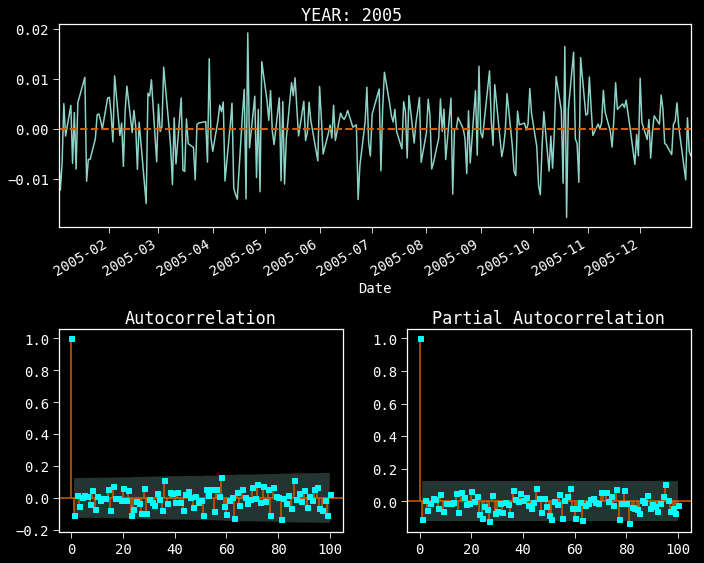

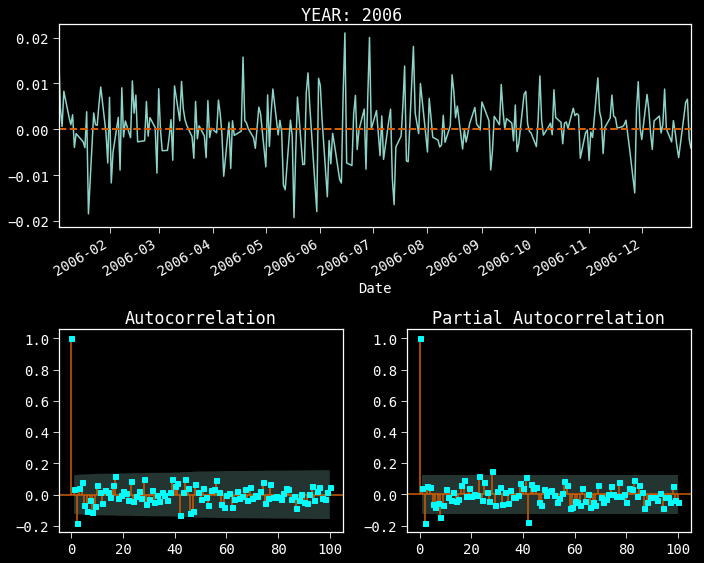

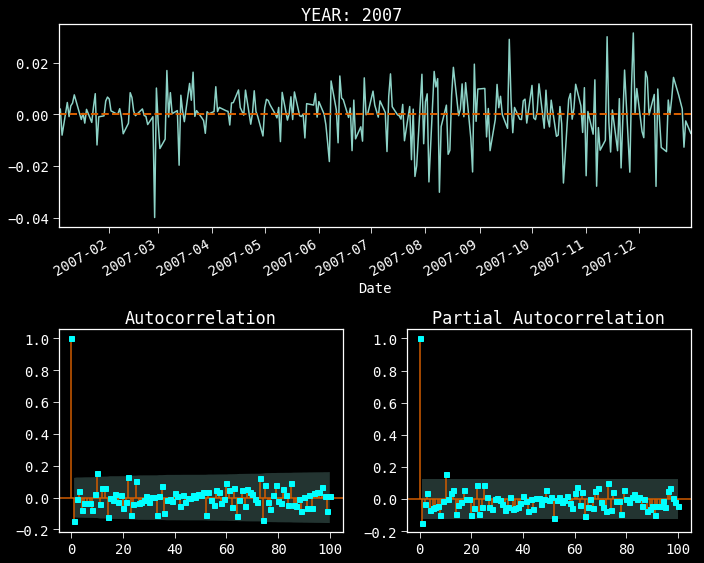

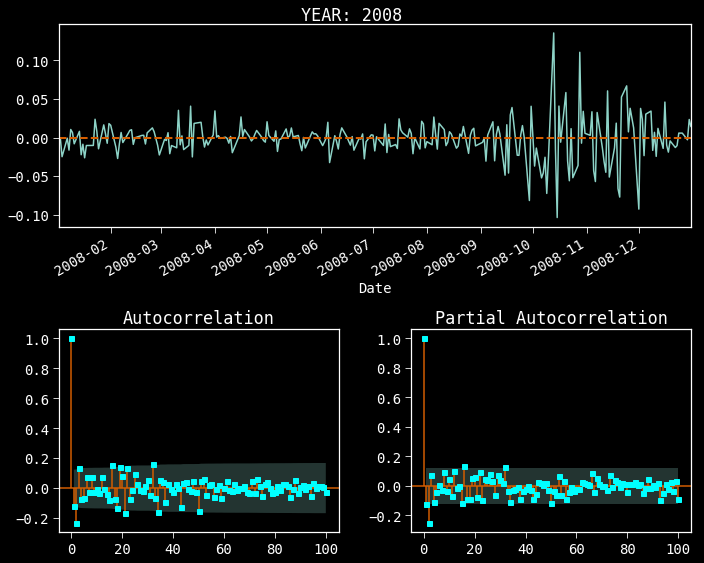

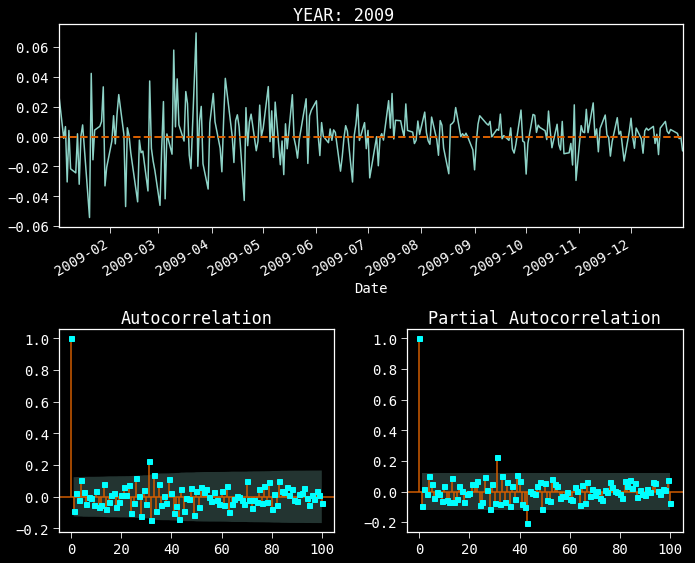

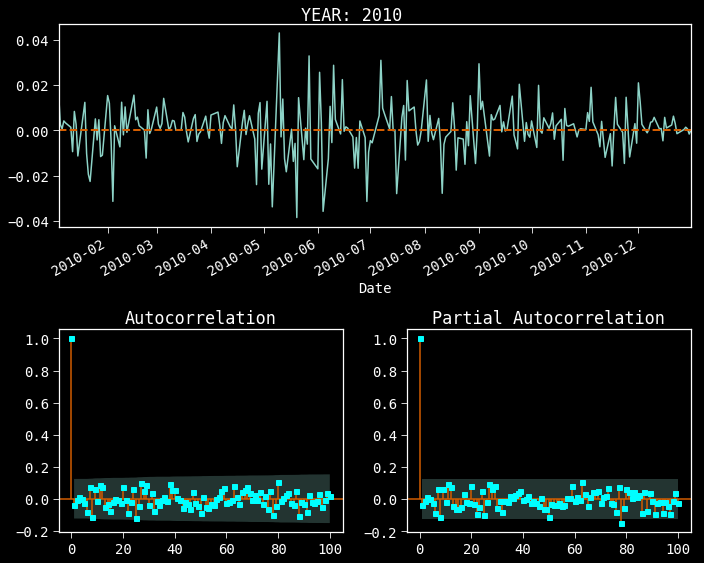

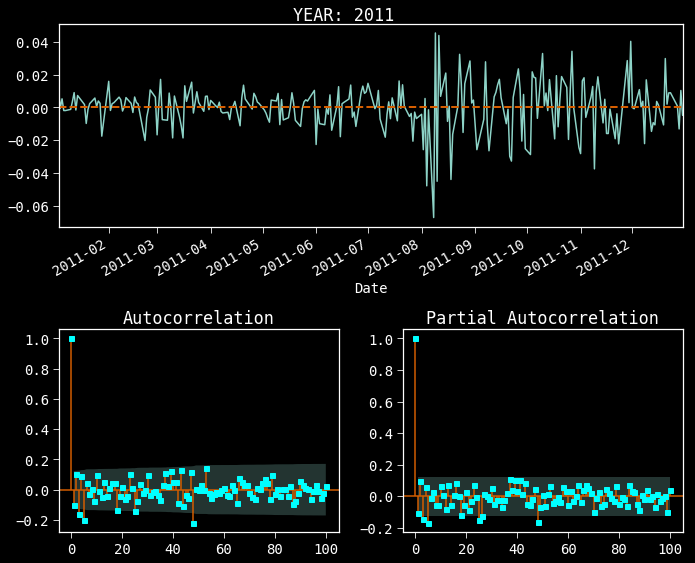

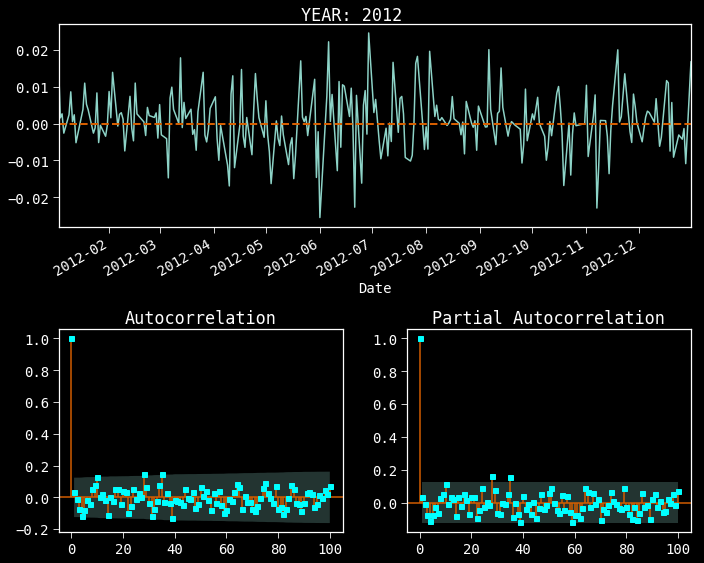

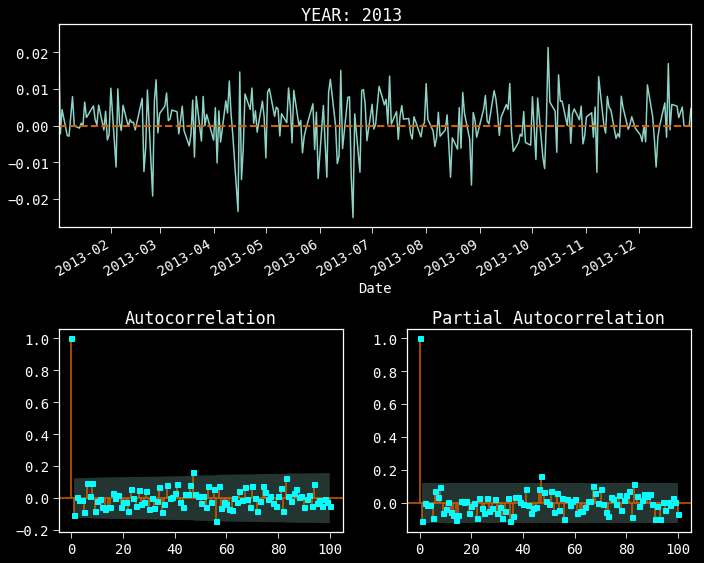

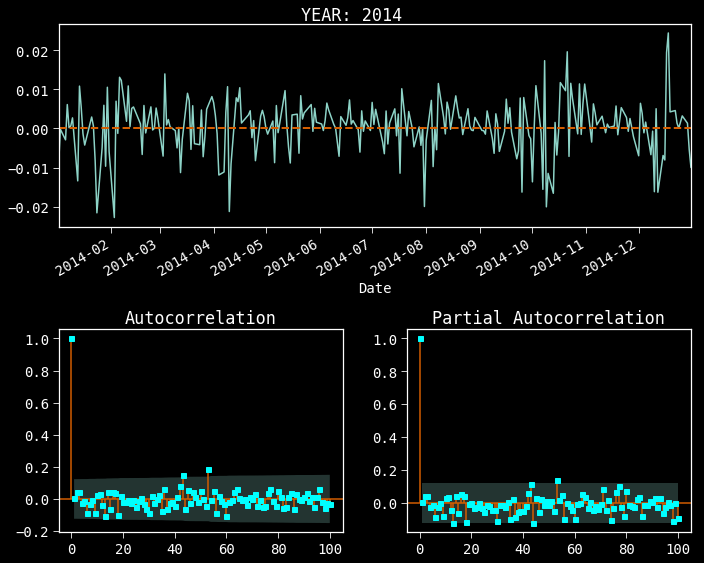

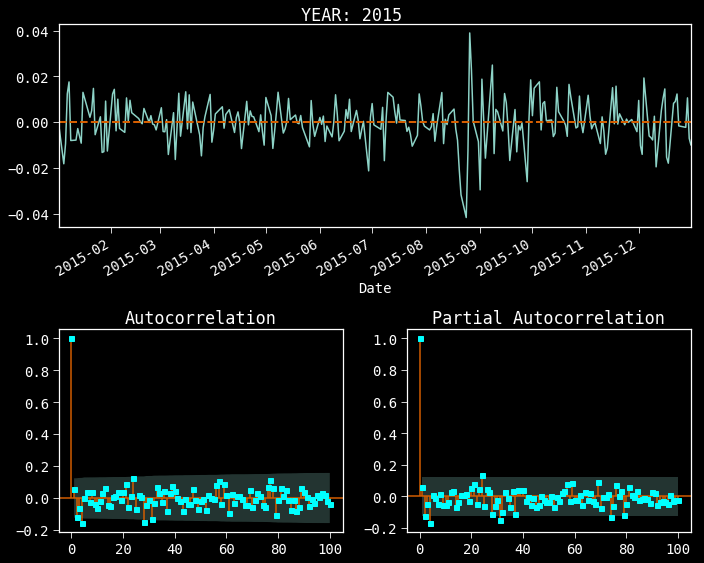

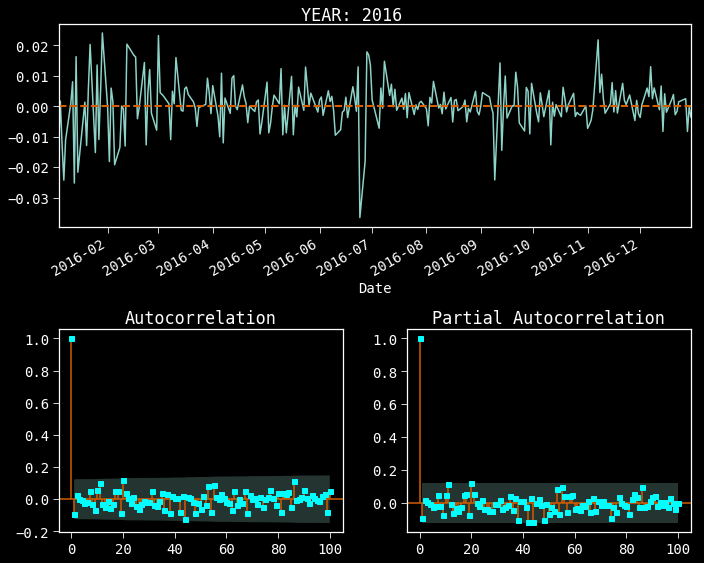

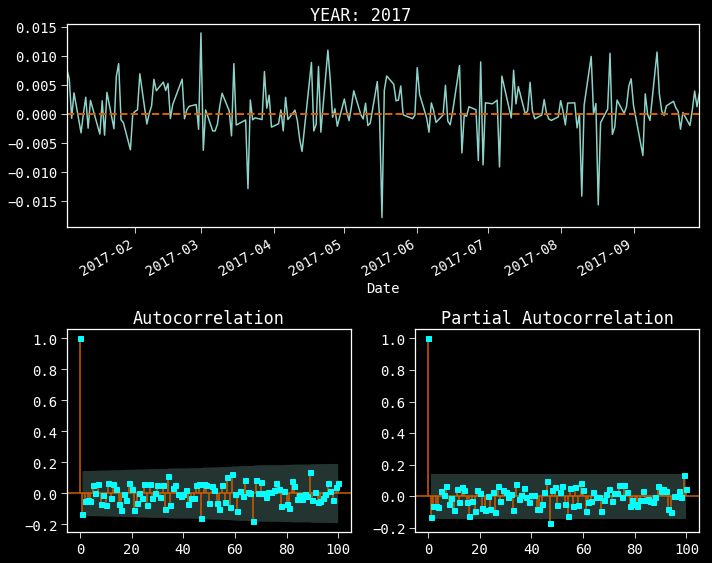

In [22]:
for year in (rs.loc['2005':].assign(year=lambda df: df.index.year)).year.unique():
    _ = tsplot(ex.loc[str(year)], lags=100)
    plt.suptitle('YEAR: {}'.format(year))
    plt.subplots_adjust(top=0.95)

So we can see clearly that SPY returns are nonstationary in the mean, in the variance, and demonstrate periods of variable autocorrelation. Furthermore we see the return distribution is mostly non-normal. So what happens when we try to use past returns approximated by a normal distribution's summary metrics (mean, variance) to predict future return distributions?

In [28]:
from sklearn.model_selection import TimeSeriesSplit

TimeSeriesSplit(max_train_size=3, n_splits=3)
[0 1 2] [3]
[1 2 3] [4]
[2 3 4] [5]


In [35]:
def generate_norm_rvs(ser, N=None, min_max=None):
    if not N:
        N = ser.shape[0]
    if not min_max:
        _min, _max = ser.min(), ser.max()
        x = np.linspace(_min, _max, N)
    else:
        _min, _max = min_max
        x = np.linspace(_min, _max, N)
    y = norm(ser.mean(), ser.std()).pdf(x)
    return x, y

In [41]:
xx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 1 columns):
SPY    3209 non-null float64
dtypes: float64(1)
memory usage: 210.1 KB


In [71]:
_base = 252 # 1 trading year
_max_train_sizes = [_base*1, _base*2, _base*3, _base*5]
_splits = np.arange(2, 12, 2)

sum([len(_max_train_sizes) * i for i in _splits]), _splits, _splits.sum()

(120, array([ 2,  4,  6,  8, 10]), 30)

In [ ]:
%%time

xx = ex.copy() # pd series representing example data

gs = gridspec.GridSpec(_splits.sum(), len(_max_train_sizes))

fig = plt.figure(figsize=(40,90))

n_split=5 # try with different values

rows = []
for j, max_size in enumerate(_max_train_sizes):
    tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=max_size)
    
    for i, (train, test) in enumerate(tscv.split(xx)):
        tmp_train = xx.iloc[train] # temporary train data
        tmp_test = xx.iloc[test] # temporary test data
        
        # get date ranges for datasets
        min_train_dt, max_train_dt = tmp_train.index.min(), tmp_train.index.max()
        min_test_dt, max_test_dt = tmp_test.index.min(), tmp_test.index.max()
        
        # compare train distro vs test distro 
        #   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
        ks, p = stats.ks_2samp(tmp_train, tmp_test) # get ks statistic and pvalue
        
        df_row = (max_size, ks, p, min_train_dt.date(), max_train_dt.date(), min_test_dt.date(), max_test_dt.date())
        rows.append(df_row) # append data for df
        
        tmp_ax = plt.subplot(gs[i, j]) # get temp ax from gridspec object
        sns.kdeplot(tmp_train, cumulative=True, lw=3, color=blue, ax=tmp_ax, label='train')
        sns.kdeplot(tmp_test, cumulative=True, lw=3, color=red, ax=tmp_ax, label='test')
        plt.title('max train size: {}, ks: {:.4f}, p: {:.4f}\ntrain dates: {}_{}\ntest dates: {}_{}'.
                     format(max_size, ks, p,
                            min_train_dt.date(), max_train_dt.date(),
                            min_test_dt.date(), max_test_dt.date())
                  , fontsize=11.)
        plt.subplots_adjust(top=1.03) # adjust title spacing
        plt.tight_layout()
#plt.savefig('spy return cdf compare-time series split {} folds-kstest.png'.format(n_split), dpi=300, bbox_inches='tight') 

In [104]:
# create data table with ks test results and tss information

cols = ['max_size', 'ks', 'p', 'min_train_dt', 'max_train_dt', 'min_test_dt', 'max_test_dt']
tss_ks_df = pd.DataFrame(rows, columns=cols)
obj_cols = tss_ks_df.select_dtypes(include=['object']).columns
tss_ks_df[obj_cols] = tss_ks_df[obj_cols].apply(pd.to_datetime)
tss_ks_df

,max_size,ks,p,min_train_dt,max_train_dt,min_test_dt,max_test_dt
0,252,0.2284,0.0000,2006-02-23,2007-02-23,2007-02-26,2009-04-07
1,252,0.2067,0.0000,2008-04-09,2009-04-07,2009-04-08,2011-05-19
2,252,0.0491,0.7941,2010-05-21,2011-05-19,2011-05-20,2013-07-05
3,252,0.0490,0.7950,2012-07-03,2013-07-05,2013-07-08,2015-08-18
4,252,0.0817,0.1945,2014-08-19,2015-08-18,2015-08-19,2017-09-29
5,504,0.2077,0.0000,2005-02-23,2007-02-23,2007-02-26,2009-04-07
6,504,0.1505,0.0000,2007-04-10,2009-04-07,2009-04-08,2011-05-19
7,504,0.0492,0.5460,2009-05-21,2011-05-19,2011-05-20,2013-07-05
8,504,0.0887,0.0316,2011-07-05,2013-07-05,2013-07-08,2015-08-18
9,504,0.0632,0.2442,2013-08-19,2015-08-18,2015-08-19,2017-09-29


In [110]:
get_pct_reject = lambda df, col, alpha: df.query('{} < {}'.format(col, alpha)).shape[0] / df.shape[0]

a1 = 0.05
a2 = 0.01

get_pct_reject(tss_ks_df, 'p', a1), get_pct_reject(tss_ks_df, 'p', a2) 

(0.6, 0.35)

In [111]:
tss_ks_df.query('p > 0.05')

,max_size,ks,p,min_train_dt,max_train_dt,min_test_dt,max_test_dt
2,252,0.0491,0.7941,2010-05-21,2011-05-19,2011-05-20,2013-07-05
3,252,0.0490,0.7950,2012-07-03,2013-07-05,2013-07-08,2015-08-18
4,252,0.0817,0.1945,2014-08-19,2015-08-18,2015-08-19,2017-09-29
7,504,0.0492,0.5460,2009-05-21,2011-05-19,2011-05-20,2013-07-05
9,504,0.0632,0.2442,2013-08-19,2015-08-18,2015-08-19,2017-09-29
14,756,0.0657,0.1291,2012-08-15,2015-08-18,2015-08-19,2017-09-29
16,1260,0.0664,0.0829,2005-01-03,2009-04-07,2009-04-08,2011-05-19
17,1260,0.0426,0.4949,2006-05-19,2011-05-19,2011-05-20,2013-07-05


Unsurprisingly the results are terrible. It's almost like they came from two different distributions (shocker). 

In [53]:
# demonstrate with the laplace and johnson su dist

For this example lets assume the total return is series is length $N$.

What if we were to look at the each year's summary statistics as being sourced from _$K$_ different distributions with $K << N$? 

To elaborate, we can look across the time series and try to guess which year's returns come from distribution $k_1$, $k_2$...$k_m$. Building on that concept then, if our distribution assignment is good enough(c) we can use the parameters for $k_i$ with returns $r$ ~ ($\mu_i$,$\sigma_i$), as the input to our predicted future return distribution.